In [1]:
import sys, os
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from pathlib import Path

from allen_v1dd.client import OPhysClient

sys.path.insert(0, '/home/naomi/Desktop/code/v1dd-public/analysis-runner')
import decoding

In [2]:
mouse_id = 'M427836'
col_vol_str = '22'
plane = 3
plane_name = f"Plane_{plane}"

# DATA_DIR = Path("/home/roozbehf/Documents/v1dd_arefeh/V1_DD_NWBs/")
DATA_DIR = Path("/home/naomi/Desktop/data/V1dd_nwbs/")
assert DATA_DIR.exists()
DATA_DIR.resolve()
client =  OPhysClient(DATA_DIR)
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")

dff_traces = session.get_traces(trace_type='dff', plane=plane)

Optimal k: 1
Cross-validation accuracy with optimal k: 0.4642


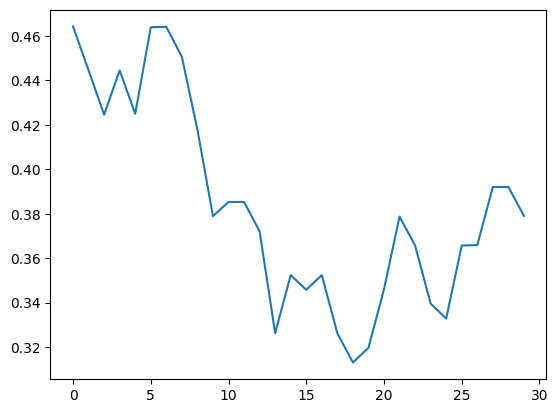

In [3]:
# stim = "natural_images"
# decode_dim = "image_index"
stim = "drifting_gratings_windowed"
decode_dim = "direction"

x_data = decoding.get_X_data(session, plane, stim)  # T x N
y_data = decoding.get_Y_data(session, plane, stim, decode_dim=decode_dim)

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

param_grid = {'n_neighbors': list(range(1, len(y_train) // 5 + 1))}  # 5-fold cross-validation

knn = KNeighborsClassifier(metric='correlation')
grid_search = GridSearchCV(knn, param_grid, cv=4, scoring='accuracy')
grid_search.fit(x_train, y_train)
best_k = grid_search.best_params_['n_neighbors']
print(f"Optimal k: {best_k}")
print(f"Cross-validation accuracy with optimal k: {grid_search.best_score_:.4f}")

import matplotlib.pyplot as plt
plt.plot(grid_search.cv_results_['mean_test_score'])

In [4]:
knn = KNeighborsClassifier(n_neighbors=best_k, metric='correlation')
knn.fit(x_train, y_train)
y_pred_train = knn.predict(x_train)
y_pred_test = knn.predict(x_test)

print(f"Train accuracy: {metrics.accuracy_score(y_train, y_pred_train):.4f}")
print(f"Test accuracy: {metrics.accuracy_score(y_test, y_pred_test):.4f}")

Train accuracy: 1.0000
Test accuracy: 0.4872


In [5]:
import numpy as np

In [6]:
stim = "natural_images_12"
decode_dim = "image_index"
# stim = "drifting_gratings_windowed"
# decode_dim = "direction"

x_data = decoding.get_X_data(session, plane, stim)  # T x N
y_data = decoding.get_Y_data(session, plane, stim, decode_dim=decode_dim)

In [7]:
folds = 5
train_accuracies, test_accuracies = [], []
shuf_train_accuracies, shuf_test_accuracies = [], []

for shuf_type in [False, True]:

    for i in range(folds):
    #     if shuf_type:
    #         print(f"Fold {i + 1}, Shuffled labels")
    #     else:
    #         print(f"Fold {i + 1}, Original labels")
        
        # Split data into training and testing sets, set random state for reproducibility
        x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=i)

        if shuf_type:
            np.random.shuffle(y_train)
        
        # Perform grid search for optimal k
        param_grid = {'n_neighbors': list(range(1, len(y_train) // folds + 1))}
        knn = KNeighborsClassifier(metric='correlation')
        grid_search = GridSearchCV(knn, param_grid, cv=folds, scoring='accuracy')
        grid_search.fit(x_train, y_train)
        
        best_k = grid_search.best_params_['n_neighbors']
        # print(f"Optimal k for fold {i + 1}: {best_k}")
        
        # Fit the model with the best k
        knn = KNeighborsClassifier(n_neighbors=best_k, metric='correlation')
        knn.fit(x_train, y_train)
        
        y_pred_train = knn.predict(x_train)
        y_pred_test = knn.predict(x_test)
        
        train_accuracy = metrics.accuracy_score(y_train, y_pred_train)
        test_accuracy = metrics.accuracy_score(y_test, y_pred_test)
        
        if shuf_type:
            shuf_train_accuracies.append(train_accuracy)
            shuf_test_accuracies.append(test_accuracy)
            print(f"Shuffled train accuracy for fold {i + 1}: {train_accuracy:.4f}")
            print(f"Shuffled test accuracy for fold {i + 1}: {test_accuracy:.4f}")
        else:
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)
            print(f"Train accuracy for fold {i + 1}: {train_accuracy:.4f}")
            print(f"Test accuracy for fold {i + 1}: {test_accuracy:.4f}")


Train accuracy for fold 1: 0.4089
Test accuracy for fold 1: 0.2708
Train accuracy for fold 2: 0.3984
Test accuracy for fold 2: 0.2604
Train accuracy for fold 3: 0.4401
Test accuracy for fold 3: 0.2812
Train accuracy for fold 4: 0.4245
Test accuracy for fold 4: 0.2604
Train accuracy for fold 5: 0.4141
Test accuracy for fold 5: 0.3542
Shuffled train accuracy for fold 1: 0.1536
Shuffled test accuracy for fold 1: 0.0208
Shuffled train accuracy for fold 2: 0.1484
Shuffled test accuracy for fold 2: 0.0833
Shuffled train accuracy for fold 3: 0.2031
Shuffled test accuracy for fold 3: 0.0833
Shuffled train accuracy for fold 4: 0.2370
Shuffled test accuracy for fold 4: 0.0729
Shuffled train accuracy for fold 5: 0.1823
Shuffled test accuracy for fold 5: 0.0625


## Testing new function

In [8]:
from decoding import run_decoding_v2
import pandas as pd

In [9]:
data_folder = "/home/naomi/Desktop/data/"
mouse_id, col_vol_str

('M427836', '22')

In [10]:
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")
planes = [1, 2, 3]
stimulus_type = "drifting_gratings_windowed"
repetitions = 2
decode_dim = "direction"
folds = 5
bootstrap = False
bootstrap_size = 1
metrics_df = pd.read_csv(f"{data_folder}/all_metrics_240426.csv")
unduplicated = True
folder_name = data_folder
save_decoding = False
results_folder = f"{data_folder}/decoding_results"
tag = "20250728_1"

decoding_results = run_decoding_v2(
    session=session,
    plane=plane,
    stimulus_type=stimulus_type,
    repetitions=repetitions,
    decode_dim=decode_dim,
    folds=folds,
    bootstrap=bootstrap,
    bootstrap_size=bootstrap_size,
    metrics_df=metrics_df,
    unduplicated=unduplicated,
    folder_name=folder_name,
    save_decoding=save_decoding,
    results_folder=results_folder,
    tag=tag
)

In [11]:
# decoding_results = run_decoding_v2(
#     session=session,
#     plane=plane,
#     stimulus_type=stimulus_type,
#     repetitions=repetitions,
#     decode_dim=decode_dim,
#     folds=folds,
#     bootstrap=bootstrap,
#     bootstrap_size=bootstrap_size,
#     metrics_df=metrics_df,
#     unduplicated=unduplicated,
#     folder_name=folder_name,
#     save_decoding=save_decoding,
#     results_folder=results_folder,
#     tag=tag
# )

### Dev run_decoding_v3 (for grouping planes together)

In [12]:
import decoding

In [19]:
session = client.load_ophys_session(f"{mouse_id}_{col_vol_str}")
planes = [4, 5, 6] #[1, 2, 3] # or [4, 5, 6]
stimulus_type = "drifting_gratings_windowed"
repetitions = 2
decode_dim = "direction"
folds = 5
bootstrap = True
bootstrap_size = 250
metrics_df = pd.read_csv(f"{data_folder}/all_metrics_240426.csv")
unduplicated = True
folder_name = data_folder
save_decoding = False
results_folder = f"{data_folder}/decoding_results"
tag = "20250728_3"

decoding_results = decoding.run_decoding_v3(
    session=session,
    planes=planes,
    stimulus_type=stimulus_type,
    repetitions=repetitions,
    decode_dim=decode_dim,
    folds=folds,
    bootstrap=bootstrap,
    bootstrap_size=bootstrap_size,
    metrics_df=metrics_df,
    unduplicated=unduplicated,
    folder_name=folder_name,
    save_decoding=save_decoding,
    results_folder=results_folder,
    tag=tag
)

In [20]:
decoding_results

,mouse_id,column_id,volume_id,planes,repetition_num,test_accuracies,test_accuracies_mean,test_accuracies_std,shuf_test_accuracies,shuf_test_accuracies_mean,shuf_test_accuracies_std,num_k_neighbors,shuf_num_k_neighbors
0,427836,2,2,"[4, 5, 6]",0,"[0.4358974358974359, 0.2564102564102564, 0.384...",0.374359,0.061964,"[0.05128205128205128, 0.02564102564102564, 0.0...",0.035897,0.012561,"[7, 8, 5, 5, 4]","[16, 2, 7, 20, 1]"
1,427836,2,2,"[4, 5, 6]",1,"[0.358974358974359, 0.23076923076923078, 0.282...",0.287179,0.044114,"[0.15384615384615385, 0.1282051282051282, 0.07...",0.097436,0.044114,"[10, 20, 6, 12, 16]","[1, 1, 7, 12, 30]"
